In [1]:
# This cell is important if you want to analyze model output via shap.

# On galatea:
# shap is installed locally while mne is installed globally
# shap comes with numba and mne wants to access it, but cannot due to wrong location
# This is a workaround:
try:
    import mne
    import shap
except:
    import subprocess
    import sys
    import pip
    
    # This command will soon fail.
    pip.main(['uninstall', 'numba'])
    
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    import mne
    install('numba')
    import shap

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


generated new fontManager


In [2]:
import tensorflow as tf
import shap
import numpy as np
layers = tf.keras.layers

inp = layers.Input((512,160,1))
out = layers.Flatten()(inp)
out = layers.Dense(1)(out)
m = tf.keras.models.Model(inp,out)
background = np.random.randn(150,512,160)
X = np.random.randn(2,2000,160)


# Gradient Explainer
e = shap.GradientExplainer(m,background[:,:,:,np.newaxis])
sv = e.shap_values(X[:1,1000:1512,:,np.newaxis])



In [7]:
from importlib import reload
reload(model_zoo)

r


<module 'libs.model_zoo' from '/tf/TeleBrain/Biomag21/libs/model_zoo.py'>

In [4]:
m2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 160, 1) 0                                            
__________________________________________________________________________________________________
temporal_conv_relu (Conv2D)     (None, 512, 160, 32) 416         input_2[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 160, 32) 0           temporal_conv_relu[0][0]         
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 256, 160, 32) 0           activation[0][0]                 
____________________________________________________________________________________________

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()
from IPython.core.magic import register_cell_magic
@register_cell_magic
def run_and_save(line, cell):
    'Run and save python code block to a file'
    with open(line, 'wt') as fd:
        fd.write(cell)
    code = compile(cell, line, 'exec')
    exec(code, globals())

!nvidia-smi
!pip install mne
!pip install tensorflow-addons
!pip install scikit-learn
!pip install tqdm
!pip install tabulate

import os
try:
    networkname="../results/test"
    os.makedirs(networkname)
except:
    print('Exists')

Mon Mar  8 18:34:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 30%   30C    P2    62W / 250W |  10566MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
%%run_and_save {networkname}/config.py

import matplotlib
from libs import GeneratorCNN
matplotlib.interactive(False)
from importlib import reload
import gc
from libs import model_zoo
import BaseLineModel as approach
import numpy as np
from importlib import reload
from libs import utils
from libs.utils import Bunch
from libs import Multi_Class_Metrics as mcm
from tensorflow.keras import callbacks

reload(approach)
reload(utils)
reload(GeneratorCNN)
reload(model_zoo)
network = model_zoo.SpatialTemporalMultiClass#Channel_Decision_Small_Shared_Out#Channel_Decision_Small#ConnectivityModel#EEGNetLawhern#ConnectivityModel#SpatialTemporalMultiClass#ConnectivityModel#Channel_Decision_Small#Channel_Decision_Model#ShallowConvNetMultiClass#SpatialTemporalMultiClass#ShallowConvNetMultiClassLinear##SpatialAverageModel# ConnectivityModel#
gc.collect()
use_stable=True
subjects = {'dementia':[],'control':[],'mci':[]}
utils.get_subjects_wrt_site(subjects,30,30,'dementia')
utils.get_subjects_wrt_site(subjects,100,100,'control')
utils.get_subjects_wrt_site(subjects,1,15,'mci')
subjects['dementia'].remove(27)

use_stable='all'
if use_stable=='order0':
    channel_matches = np.load('pareto_opt_matches.npy')
    channel_matches = utils.get_stable_channels(channel_matches,0).T#[:,44:46]
elif use_stable=='all':
    import json
    with open('A_B_bestpositional_hungarian.json') as f:
        match = json.load(f)
    match['matching0'].pop('info')
    channel_matches = np.array([list(match['matching0'].keys()),list(match['matching0'].values())]).astype(int)
elif use_stable is None:
    channel_matches = np.stack([np.arange(160),np.arange(160)])

site_as_label = False
if site_as_label:
    num_classes = 2
else:
    num_classes = 3


sensitivity_mci_dem = mcm.MultiClassRecall(num_classes=num_classes,
                                           pos_ind=[1,2],
                                           average='macro',
                                           name="mci_dem_sensitivity")
specificity_mci_dem = mcm.MultiClassSpecificity(num_classes=num_classes,
                                                pos_ind=[1,2],
                                                average='macro',
                                                name="mci_dem_Specificity")
f1_mci_dem = mcm.MultiClassF1(num_classes=num_classes,
                              pos_ind=[1,2],average='macro',
                              name="mci_dem_F1")
metrics = ['acc', sensitivity_mci_dem, specificity_mci_dem,f1_mci_dem]


callbacks = [callbacks.EarlyStopping(patience=5,
                                     restore_best_weights=True,
                                     monitor="val_mci_dem_F1",
                                     mode='max',
                                     verbose=1)]
frame_size = utils.Bunch(value=2,unit='s')
fs = 256
network_params = {
    'batch_size':16,
    'use_bn':True,
    'do_ratio':0.5,
    'numTrainEpochs':10,
    'optimizer':'adam',
    'frame_size':frame_size,
    'cross_subjects':True,
    'num_classes':num_classes,
    'n_folds':5,
    'use_class_weights':True,
    'workers':16,
    'multiprocessing':False,
    'monitor':"val_mci_dem_F1",
    'aggregation':'max',
    'site_sampling':True,
    }

data_params={
             'standardize':'em_astd',#'ema',#'look_at_time',# look_at_time
             'fs':fs,
             'channel_matches':channel_matches,
             'subjects':subjects,
             'test_ratio':0.2,
             'readSubjects_params':{
                 'site_as_label':site_as_label,
                 'l_freq':1,
                 'h_freq':40,
                 'frame_length':utils.time2samples(time_container=frame_size,fs=fs),
                 'bad_samples_path':r'../cache/bad_samples',
                 'utility_data':r'../cache/utility_data'
                 },
            }
# the first 80 magnetic poles contain the inner magnetic field
SA  = np.load('SA.npy')[:,:80]
SB  = np.load('SB.npy')[:,:80]
pSA = np.load('pSA.npy')[:80]
pSB = np.load('pSB.npy')[:80]

# Build augmentation pipeline for Generator
function_params = {}
function_params['draw_random_time_frame']={
   'frame_length':utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),
   'trial_length':5*60*data_params['fs']}
function_params['additive_correlated_noise']={'sigma_noise':5e-2}
function_params['transform_recording_site']={'sensor_inv':[pSA,pSB],
                                             'sensor_fwd':[SA,SB],
                                             'map_to':'random'}
function_params['apply_channel_matches']={'matches':data_params['channel_matches']}

functions=[GeneratorCNN.draw_random_time_frame,
           GeneratorCNN.additive_correlated_noise,
           GeneratorCNN.transform_recording_site,
           GeneratorCNN.apply_channel_matches
           ]

prob = {'apply_channel_matches':1.0,
        'draw_random_time_frame':1.0,
        'transform_recording_site':1.0,
        'additive_correlated_noise':0.5,
        }

train_aug_pipe=GeneratorCNN.Augment_Pipeline(functions=functions,
                                  params=function_params,
                                  p=prob)
func = [
        GeneratorCNN.draw_random_time_frame,
        GeneratorCNN.transform_recording_site,
        GeneratorCNN.apply_channel_matches]
p = {'transform_recording_site':1,'apply_channel_matches':1,'draw_random_time_frame':1}
aug_params = {
    'transform_recording_site':
       {'map_to':'identity',
        'sensor_inv':[pSA,pSB],
        'sensor_fwd':[SA,SB]},
    'apply_channel_matches':
        {'matches':data_params['channel_matches']},
    'draw_random_time_frame':
        {'frame_length':utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),
        'trial_length':5*60*data_params['fs']}
        }
valid_pipe = GeneratorCNN.Augment_Pipeline(func,aug_params,p)

def get_test_objects(fold,network):
    overlap = 256
    func = [
            GeneratorCNN.draw_continuous_time_frame,
            GeneratorCNN.transform_recording_site,
            GeneratorCNN.apply_channel_matches]
    p = {'transform_recording_site':1,'apply_channel_matches':1,'draw_continuous_time_frame':1}
    aug_params = {
        'transform_recording_site':
           {'map_to':'identity',
            'sensor_inv':[pSA,pSB],
            'sensor_fwd':[SA,SB]},
        'apply_channel_matches':
            {'matches':data_params['channel_matches']},
        'draw_continuous_time_frame':
            {'frame_length':utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),
            #'trial_length':5*60*data_params['fs']
             'overlap':overlap
             }
            }
    test_pipe = GeneratorCNN.Augment_Pipeline(func,aug_params,p)
    test_pipe.params['overlap']=overlap
    input_shape = (512,160,1)
    model = network(input_shape,network_params)
    model = trainer.load_model(fold,model=model)
    from tensorflow.keras import models
    feature_model = models.Model(model.input,model.layers[-3].output)
    return test_pipe, model, feature_model

r


reload(mcm)
reload(GeneratorCNN)
reload(approach.GeneratorCNN)
reload(utils)
reload(model_zoo)
reload(approach)
reload(approach.readSubjects)

In [44]:
reload(approach)

trainer = approach.RunTraining(dataDir=r'../cache/raw',
                               train_path_info='./info',
                               static_data_params=data_params,
                               network_params=network_params,
                               completeDir=networkname)

In [34]:
last_model = trainer.start_main(network=network,
                                train_augment_pipeline=train_aug_pipe,
                                valid_augment_pipeline=valid_pipe,
                                metrics=metrics,
                                callbacks_list=callbacks)

Function 'start_main' was already run in this folder.                 Either delete this folder or use 'continue_training'


In [45]:

for fold in np.arange(0,1,1):
    model = trainer.continue_training(fold,network,metrics=metrics,
                                           callbacks_list=callbacks)
    del model
    test_pipe, last_model, feature_model = get_test_objects(fold,network)
    results = trainer.test_model(last_model,test_pipe,fold=fold,keep_data=True, 
                                 data_loaded=False,iterative=False)
    conf_mat = trainer.evaluate3classes(results[0],results[1],fold=fold,metrics=metrics[1:])
    """
    results_features_test = trainer.test_model(feature_model,test_pipe,fold,
                                                 keep_data=False,data_loaded=True,
                                                 subject_group='test_subjects.json',
                                                 iterative=False,
                                                 make_classification=False)
    results_features_train = trainer.test_model(feature_model,test_pipe,fold,
                                                 keep_data=False,data_loaded=False,
                                                 subject_group='train_subjects.json',
                                                iterative=True,
                                                make_classification=False)
    """

Model folder already exists. Do you want to continue? Y,N Y


{'mci': 12, 'dementia': 22, 'control': 79}


  0%|          | 0/113 [00:00<?, ?it/s]


Opening raw data file ../cache/raw/100Hzcontrol018raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  1%|          | 1/113 [00:00<01:25,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol019raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  2%|▏         | 2/113 [00:01<01:27,  1.27it/s]

Opening raw data file ../cache/raw/100Hzcontrol020raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  3%|▎         | 3/113 [00:02<01:25,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol023raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  4%|▎         | 4/113 [00:03<01:26,  1.26it/s]

Opening raw data file ../cache/raw/100Hzcontrol026raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  4%|▍         | 5/113 [00:03<01:25,  1.27it/s]

Opening raw data file ../cache/raw/100Hzcontrol027raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  5%|▌         | 6/113 [00:04<01:24,  1.27it/s]

Opening raw data file ../cache/raw/100Hzcontrol028raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  6%|▌         | 7/113 [00:05<01:22,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol029raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  7%|▋         | 8/113 [00:06<01:20,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol030raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  8%|▊         | 9/113 [00:06<01:20,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol031raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  9%|▉         | 10/113 [00:07<01:19,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol032raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 10%|▉         | 11/113 [00:08<01:17,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol033raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 11%|█         | 12/113 [00:09<01:16,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol034raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 12%|█▏        | 13/113 [00:09<01:14,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol035raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 12%|█▏        | 14/113 [00:10<01:13,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol036raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 13%|█▎        | 15/113 [00:11<01:12,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol037raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 14%|█▍        | 16/113 [00:12<01:11,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol038raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 15%|█▌        | 17/113 [00:12<01:11,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol039raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 16%|█▌        | 18/113 [00:13<01:10,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol040raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 17%|█▋        | 19/113 [00:14<01:10,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol041raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 18%|█▊        | 20/113 [00:15<01:09,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol042raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 19%|█▊        | 21/113 [00:15<01:08,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol043raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 19%|█▉        | 22/113 [00:16<01:09,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol044raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 20%|██        | 23/113 [00:17<01:08,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol045raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 21%|██        | 24/113 [00:18<01:07,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol046raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 22%|██▏       | 25/113 [00:18<01:07,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol047raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 23%|██▎       | 26/113 [00:19<01:05,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol048raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 24%|██▍       | 27/113 [00:20<01:05,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol049raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 25%|██▍       | 28/113 [00:21<01:04,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol050raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 26%|██▌       | 29/113 [00:22<01:03,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol051raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 27%|██▋       | 30/113 [00:22<01:02,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol052raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 27%|██▋       | 31/113 [00:23<01:01,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol053raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 28%|██▊       | 32/113 [00:24<01:00,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol054raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 29%|██▉       | 33/113 [00:24<00:59,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol055raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 30%|███       | 34/113 [00:25<00:59,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol056raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 31%|███       | 35/113 [00:26<00:58,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol057raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 32%|███▏      | 36/113 [00:27<00:58,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol058raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 33%|███▎      | 37/113 [00:27<00:56,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol059raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 34%|███▎      | 38/113 [00:28<00:55,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol060raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 35%|███▍      | 39/113 [00:29<00:55,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol061raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 35%|███▌      | 40/113 [00:30<00:54,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol062raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 36%|███▋      | 41/113 [00:30<00:53,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol063raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 37%|███▋      | 42/113 [00:31<00:52,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol064raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 38%|███▊      | 43/113 [00:32<00:51,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol065raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 39%|███▉      | 44/113 [00:33<00:51,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol066raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 40%|███▉      | 45/113 [00:33<00:50,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol067raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 41%|████      | 46/113 [00:34<00:49,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol068raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 42%|████▏     | 47/113 [00:35<00:48,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol069raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 42%|████▏     | 48/113 [00:36<00:47,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol070raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 43%|████▎     | 49/113 [00:36<00:47,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol071raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 44%|████▍     | 50/113 [00:37<00:46,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol072raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 45%|████▌     | 51/113 [00:38<00:45,  1.36it/s]

Opening raw data file ../cache/raw/100Hzcontrol073raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 46%|████▌     | 52/113 [00:39<00:45,  1.36it/s]

Opening raw data file ../cache/raw/100Hzcontrol074raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 47%|████▋     | 53/113 [00:39<00:44,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol075raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 48%|████▊     | 54/113 [00:40<00:44,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol076raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 49%|████▊     | 55/113 [00:41<00:43,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol077raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 50%|████▉     | 56/113 [00:42<00:43,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol078raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 50%|█████     | 57/113 [00:42<00:42,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol079raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 51%|█████▏    | 58/113 [00:43<00:41,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol080raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 52%|█████▏    | 59/113 [00:44<00:40,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol081raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 53%|█████▎    | 60/113 [00:45<00:39,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol082raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 54%|█████▍    | 61/113 [00:45<00:39,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol083raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 55%|█████▍    | 62/113 [00:46<00:38,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol084raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 56%|█████▌    | 63/113 [00:47<00:37,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol085raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 57%|█████▋    | 64/113 [00:48<00:36,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol086raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 58%|█████▊    | 65/113 [00:48<00:36,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol087raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 58%|█████▊    | 66/113 [00:49<00:36,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol088raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 59%|█████▉    | 67/113 [00:50<00:35,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol089raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 60%|██████    | 68/113 [00:51<00:34,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol090raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 61%|██████    | 69/113 [00:52<00:33,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol091raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 62%|██████▏   | 70/113 [00:52<00:32,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol092raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 63%|██████▎   | 71/113 [00:53<00:31,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol093raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 64%|██████▎   | 72/113 [00:54<00:30,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol094raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 65%|██████▍   | 73/113 [00:55<00:30,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol095raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 65%|██████▌   | 74/113 [00:55<00:29,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol096raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 66%|██████▋   | 75/113 [00:56<00:28,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol097raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 67%|██████▋   | 76/113 [00:57<00:27,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol098raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 68%|██████▊   | 77/113 [00:58<00:27,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol099raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 69%|██████▉   | 78/113 [00:58<00:26,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol100raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 70%|██████▉   | 79/113 [00:59<00:25,  1.32it/s]

Opening raw data file ../cache/raw/100Hzdementia006raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 71%|███████   | 80/113 [01:00<00:24,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia007raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 72%|███████▏  | 81/113 [01:01<00:24,  1.32it/s]

Opening raw data file ../cache/raw/100Hzdementia008raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 73%|███████▎  | 82/113 [01:01<00:23,  1.32it/s]

Opening raw data file ../cache/raw/100Hzdementia009raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 73%|███████▎  | 83/113 [01:02<00:22,  1.32it/s]

Opening raw data file ../cache/raw/100Hzdementia011raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 74%|███████▍  | 84/113 [01:03<00:21,  1.32it/s]

Opening raw data file ../cache/raw/100Hzdementia012raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 75%|███████▌  | 85/113 [01:04<00:20,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia013raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 76%|███████▌  | 86/113 [01:04<00:20,  1.34it/s]

Opening raw data file ../cache/raw/100Hzdementia014raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 77%|███████▋  | 87/113 [01:05<00:19,  1.35it/s]

Opening raw data file ../cache/raw/100Hzdementia015raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 78%|███████▊  | 88/113 [01:06<00:18,  1.34it/s]

Opening raw data file ../cache/raw/100Hzdementia016raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 79%|███████▉  | 89/113 [01:07<00:17,  1.34it/s]

Opening raw data file ../cache/raw/100Hzdementia017raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 80%|███████▉  | 90/113 [01:07<00:17,  1.35it/s]

Opening raw data file ../cache/raw/100Hzdementia018raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 81%|████████  | 91/113 [01:08<00:16,  1.31it/s]

Opening raw data file ../cache/raw/100Hzdementia019raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 81%|████████▏ | 92/113 [01:09<00:15,  1.32it/s]

Opening raw data file ../cache/raw/100Hzdementia020raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 82%|████████▏ | 93/113 [01:10<00:15,  1.31it/s]

Opening raw data file ../cache/raw/100Hzdementia021raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 83%|████████▎ | 94/113 [01:10<00:14,  1.29it/s]

Opening raw data file ../cache/raw/100Hzdementia022raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 84%|████████▍ | 95/113 [01:11<00:14,  1.28it/s]

Opening raw data file ../cache/raw/100Hzdementia023raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 85%|████████▍ | 96/113 [01:12<00:13,  1.29it/s]

Opening raw data file ../cache/raw/100Hzdementia024raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 86%|████████▌ | 97/113 [01:13<00:12,  1.31it/s]

Opening raw data file ../cache/raw/100Hzdementia025raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 87%|████████▋ | 98/113 [01:13<00:11,  1.31it/s]

Opening raw data file ../cache/raw/100Hzdementia026raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 88%|████████▊ | 99/113 [01:14<00:10,  1.29it/s]

Opening raw data file ../cache/raw/100Hzdementia028raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 88%|████████▊ | 100/113 [01:15<00:10,  1.30it/s]

Opening raw data file ../cache/raw/100Hzdementia029raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 89%|████████▉ | 101/113 [01:16<00:09,  1.31it/s]

Opening raw data file ../cache/raw/100Hzmci004raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 90%|█████████ | 102/113 [01:17<00:08,  1.31it/s]

Opening raw data file ../cache/raw/100Hzmci005raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 91%|█████████ | 103/113 [01:17<00:07,  1.28it/s]

Opening raw data file ../cache/raw/100Hzmci006raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 92%|█████████▏| 104/113 [01:18<00:06,  1.30it/s]

Opening raw data file ../cache/raw/100Hzmci007raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 93%|█████████▎| 105/113 [01:19<00:06,  1.30it/s]

Opening raw data file ../cache/raw/100Hzmci008raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 94%|█████████▍| 106/113 [01:20<00:05,  1.30it/s]

Opening raw data file ../cache/raw/100Hzmci009raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 95%|█████████▍| 107/113 [01:20<00:04,  1.30it/s]

Opening raw data file ../cache/raw/100Hzmci010raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 96%|█████████▌| 108/113 [01:21<00:03,  1.30it/s]

Opening raw data file ../cache/raw/100Hzmci011raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 96%|█████████▋| 109/113 [01:22<00:03,  1.31it/s]

Opening raw data file ../cache/raw/100Hzmci012raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 97%|█████████▋| 110/113 [01:23<00:02,  1.31it/s]

Opening raw data file ../cache/raw/100Hzmci013raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 98%|█████████▊| 111/113 [01:23<00:01,  1.31it/s]

Opening raw data file ../cache/raw/100Hzmci014raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 99%|█████████▉| 112/113 [01:24<00:00,  1.31it/s]

Opening raw data file ../cache/raw/100Hzmci015raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



100%|██████████| 113/113 [01:25<00:00,  1.32it/s]


Network has shape:  (512, 160, 1)
numChannels 160
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 512, 160, 1)]     0         
_________________________________________________________________
temporal_conv (Conv2D)       (None, 498, 1, 16)        38416     
_________________________________________________________________
activation_57 (Activation)   (None, 498, 1, 16)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 498, 1, 16)        64        
_________________________________________________________________
c11stride (Conv2D)           (None, 498, 1, 16)        8976      
_________________________________________________________________
activation_58 (Activation)   (None, 498, 1, 16)        0         
_________________________________________________________________
batch_nor

Pass classes=[0 1 2], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


Exponential moving z score with alpha: 0.0005
Train Patients: 
 ['control100' 'control18' 'control19' 'control20' 'control23' 'control26'
 'control27' 'control28' 'control29' 'control30' 'control32' 'control34'
 'control35' 'control36' 'control37' 'control39' 'control40' 'control41'
 'control42' 'control43' 'control44' 'control45' 'control46' 'control47'
 'control48' 'control49' 'control50' 'control51' 'control53' 'control55'
 'control56' 'control57' 'control58' 'control59' 'control60' 'control61'
 'control62' 'control63' 'control64' 'control65' 'control67' 'control68'
 'control69' 'control70' 'control71' 'control72' 'control73' 'control74'
 'control75' 'control76' 'control77' 'control78' 'control79' 'control80'
 'control81' 'control82' 'control83' 'control84' 'control85' 'control86'
 'control87' 'control89' 'control91' 'control92' 'control93' 'control94'
 'control95' 'control96' 'control97' 'control98' 'control99' 'dementia11'
 'dementia12' 'dementia13' 'dementia14' 'dementia15' 'deme

Make sure that the recording site is provided for each subject.


Epoch 1/10
946/946 [==============================] - 195s 206ms/step - loss: 0.7326 - acc: 0.6337 - mci_dem_sensitivity: 0.7067 - mci_dem_Specificity: 0.9336 - mci_dem_F1: 0.4897 - val_loss: 1.2116 - val_acc: 0.4286 - val_mci_dem_sensitivity: 0.2727 - val_mci_dem_Specificity: 0.9037 - val_mci_dem_F1: 0.1705
Epoch 2/10
946/946 [==============================] - 191s 201ms/step - loss: 0.5246 - acc: 0.7477 - mci_dem_sensitivity: 0.8277 - mci_dem_Specificity: 0.9630 - mci_dem_F1: 0.6327 - val_loss: 1.5484 - val_acc: 0.4459 - val_mci_dem_sensitivity: 0.4158 - val_mci_dem_Specificity: 0.9403 - val_mci_dem_F1: 0.2310
Epoch 3/10
946/946 [==============================] - 183s 194ms/step - loss: 0.4241 - acc: 0.7978 - mci_dem_sensitivity: 0.8579 - mci_dem_Specificity: 0.9709 - mci_dem_F1: 0.6883 - val_loss: 1.1932 - val_acc: 0.5675 - val_mci_dem_sensitivity: 0.4600 - val_mci_dem_Specificity: 0.9537 - val_mci_dem_F1: 0.2304
Epoch 4/10
946/946 [==============================] - 181s 191ms/step 

  0%|          | 0/30 [00:00<?, ?it/s]


Opening raw data file ../cache/raw/100Hzcontrol001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



Method is deprecated use 'get_site'.
  3%|▎         | 1/30 [00:00<00:24,  1.20it/s]

Opening raw data file ../cache/raw/100Hzcontrol002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



  7%|▋         | 2/30 [00:01<00:22,  1.25it/s]

Opening raw data file ../cache/raw/100Hzcontrol003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 10%|█         | 3/30 [00:02<00:21,  1.28it/s]

Opening raw data file ../cache/raw/100Hzcontrol004raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 13%|█▎        | 4/30 [00:03<00:20,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol005raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 17%|█▋        | 5/30 [00:03<00:19,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol006raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 20%|██        | 6/30 [00:04<00:18,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol007raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 23%|██▎       | 7/30 [00:05<00:17,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol008raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 27%|██▋       | 8/30 [00:06<00:17,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol009raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 30%|███       | 9/30 [00:06<00:16,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol010raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 33%|███▎      | 10/30 [00:07<00:15,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol011raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 37%|███▋      | 11/30 [00:08<00:14,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol012raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 40%|████      | 12/30 [00:09<00:13,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol013raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 43%|████▎     | 13/30 [00:09<00:12,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol014raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 47%|████▋     | 14/30 [00:10<00:12,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol015raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 50%|█████     | 15/30 [00:11<00:11,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol016raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 53%|█████▎    | 16/30 [00:12<00:10,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol017raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 57%|█████▋    | 17/30 [00:13<00:09,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol021raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 60%|██████    | 18/30 [00:13<00:09,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol022raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 63%|██████▎   | 19/30 [00:14<00:08,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol024raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 67%|██████▋   | 20/30 [00:15<00:07,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol025raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 70%|███████   | 21/30 [00:16<00:06,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 73%|███████▎  | 22/30 [00:16<00:06,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 77%|███████▋  | 23/30 [00:17<00:05,  1.32it/s]

Opening raw data file ../cache/raw/100Hzdementia003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 80%|████████  | 24/30 [00:18<00:04,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia004raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 83%|████████▎ | 25/30 [00:19<00:03,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia005raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 87%|████████▋ | 26/30 [00:19<00:03,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia010raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 90%|█████████ | 27/30 [00:20<00:02,  1.33it/s]

Opening raw data file ../cache/raw/100Hzmci001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 93%|█████████▎| 28/30 [00:21<00:01,  1.33it/s]

Opening raw data file ../cache/raw/100Hzmci002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



 97%|█████████▋| 29/30 [00:22<00:00,  1.32it/s]

Opening raw data file ../cache/raw/100Hzmci003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Exponential moving z score with alpha: 0.0005


100%|██████████| 30/30 [03:16<00:00,  6.56s/it]


| ids         |   y |   pred | site   |
|:------------|----:|-------:|:-------|
| control001  |   0 |      0 | A      |
| control002  |   0 |      0 | B      |
| control003  |   0 |      0 | A      |
| control004  |   0 |      0 | A      |
| control005  |   0 |      0 | A      |
| control006  |   0 |      0 | A      |
| control007  |   0 |      0 | A      |
| control008  |   0 |      0 | B      |
| control009  |   0 |      0 | B      |
| control010  |   0 |      0 | B      |
| control011  |   0 |      0 | A      |
| control012  |   0 |      0 | A      |
| control013  |   0 |      0 | A      |
| control014  |   0 |      0 | B      |
| control015  |   0 |      0 | A      |
| control016  |   0 |      0 | A      |
| control017  |   0 |      0 | B      |
| control021  |   0 |      0 | A      |
| control022  |   0 |      0 | A      |
| control024  |   0 |      0 | A      |
| control025  |   0 |      0 | A      |
| dementia001 |   2 |      0 | A      |
| dementia002 |   2 |      1 | B      |


In [41]:
reload(model_zoo)
m = model_zoo.SpatialTemporalMultiClass((512,160,1),network_params)
m.summary()

r
numChannels 160
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 512, 160, 1)]     0         
_________________________________________________________________
temporal_conv (Conv2D)       (None, 498, 1, 16)        38416     
_________________________________________________________________
activation_47 (Activation)   (None, 498, 1, 16)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 498, 1, 16)        64        
_________________________________________________________________
c11stride (Conv2D)           (None, 498, 1, 16)        8976      
_________________________________________________________________
activation_48 (Activation)   (None, 498, 1, 16)        0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 498, 

In [67]:
trainer.network_params['site_sampling']=False
    results = trainer.test_model(last_model,test_pipe,fold=fold,keep_data=True, 
                                 data_loaded=False,iterative=False)

{'mci': 3, 'dementia': 6, 'control': 21}


  0%|          | 0/30 [00:00<?, ?it/s]


Opening raw data file ../cache/raw/100Hzcontrol001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



  3%|▎         | 1/30 [00:00<00:23,  1.23it/s]

Opening raw data file ../cache/raw/100Hzcontrol002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



  7%|▋         | 2/30 [00:01<00:22,  1.22it/s]

Opening raw data file ../cache/raw/100Hzcontrol003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 10%|█         | 3/30 [00:02<00:21,  1.23it/s]

Opening raw data file ../cache/raw/100Hzcontrol004raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

Opening raw data file ../cache/raw/100Hzcontrol005raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 17%|█▋        | 5/30 [00:03<00:19,  1.28it/s]

Opening raw data file ../cache/raw/100Hzcontrol006raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 20%|██        | 6/30 [00:04<00:18,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol007raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 23%|██▎       | 7/30 [00:05<00:17,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol008raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 27%|██▋       | 8/30 [00:06<00:16,  1.30it/s]

Opening raw data file ../cache/raw/100Hzcontrol009raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 30%|███       | 9/30 [00:07<00:16,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol010raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 33%|███▎      | 10/30 [00:07<00:15,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol011raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 37%|███▋      | 11/30 [00:08<00:14,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol012raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 40%|████      | 12/30 [00:09<00:13,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol013raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 43%|████▎     | 13/30 [00:09<00:12,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol014raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 47%|████▋     | 14/30 [00:10<00:11,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol015raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 50%|█████     | 15/30 [00:11<00:11,  1.36it/s]

Opening raw data file ../cache/raw/100Hzcontrol016raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 53%|█████▎    | 16/30 [00:12<00:10,  1.36it/s]

Opening raw data file ../cache/raw/100Hzcontrol017raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 57%|█████▋    | 17/30 [00:12<00:09,  1.34it/s]

Opening raw data file ../cache/raw/100Hzcontrol021raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 60%|██████    | 18/30 [00:13<00:08,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol022raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 63%|██████▎   | 19/30 [00:14<00:08,  1.35it/s]

Opening raw data file ../cache/raw/100Hzcontrol024raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 67%|██████▋   | 20/30 [00:15<00:07,  1.36it/s]

Opening raw data file ../cache/raw/100Hzcontrol025raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 70%|███████   | 21/30 [00:15<00:06,  1.35it/s]

Opening raw data file ../cache/raw/100Hzdementia001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 73%|███████▎  | 22/30 [00:16<00:05,  1.35it/s]

Opening raw data file ../cache/raw/100Hzdementia002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 77%|███████▋  | 23/30 [00:17<00:05,  1.35it/s]

Opening raw data file ../cache/raw/100Hzdementia003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 80%|████████  | 24/30 [00:18<00:04,  1.35it/s]

Opening raw data file ../cache/raw/100Hzdementia004raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 83%|████████▎ | 25/30 [00:18<00:03,  1.34it/s]

Opening raw data file ../cache/raw/100Hzdementia005raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 87%|████████▋ | 26/30 [00:19<00:03,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia010raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 90%|█████████ | 27/30 [00:20<00:02,  1.34it/s]

Opening raw data file ../cache/raw/100Hzmci001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 93%|█████████▎| 28/30 [00:21<00:01,  1.33it/s]

Opening raw data file ../cache/raw/100Hzmci002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 97%|█████████▋| 29/30 [00:21<00:00,  1.33it/s]

Opening raw data file ../cache/raw/100Hzmci003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Exponential moving z score with alpha: 0.0005


  0%|          | 0/30 [00:00<?, ?it/s]

1
[1]
[1.]


  3%|▎         | 1/30 [00:07<03:26,  7.13s/it]

1
[1]
[1.]


  7%|▋         | 2/30 [00:14<03:18,  7.10s/it]

1
[1]
[1.]


 10%|█         | 3/30 [00:21<03:10,  7.06s/it]

1
[1]
[1.]


 10%|█         | 3/30 [00:24<03:38,  8.11s/it]


KeyboardInterrupt: 

In [137]:
reload(approach.utils)
results = trainer.test_model(last_model,test_pipe,fold=fold,keep_data=True, 
                             data_loaded=False,iterative=False)

{'mci': 3, 'dementia': 6, 'control': 21}


  0%|          | 0/30 [00:00<?, ?it/s]


Opening raw data file ../cache/raw/100Hzcontrol001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



  3%|▎         | 1/30 [00:00<00:24,  1.20it/s]

Opening raw data file ../cache/raw/100Hzcontrol002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



  7%|▋         | 2/30 [00:01<00:22,  1.26it/s]

Opening raw data file ../cache/raw/100Hzcontrol003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 10%|█         | 3/30 [00:02<00:21,  1.27it/s]

Opening raw data file ../cache/raw/100Hzcontrol004raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 13%|█▎        | 4/30 [00:03<00:20,  1.25it/s]

Opening raw data file ../cache/raw/100Hzcontrol005raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 17%|█▋        | 5/30 [00:03<00:19,  1.27it/s]

Opening raw data file ../cache/raw/100Hzcontrol006raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 20%|██        | 6/30 [00:04<00:18,  1.28it/s]

Opening raw data file ../cache/raw/100Hzcontrol007raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol008raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 27%|██▋       | 8/30 [00:06<00:17,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol009raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 30%|███       | 9/30 [00:07<00:16,  1.28it/s]

Opening raw data file ../cache/raw/100Hzcontrol010raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 33%|███▎      | 10/30 [00:07<00:15,  1.28it/s]

Opening raw data file ../cache/raw/100Hzcontrol011raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 37%|███▋      | 11/30 [00:08<00:14,  1.29it/s]

Opening raw data file ../cache/raw/100Hzcontrol012raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 40%|████      | 12/30 [00:09<00:13,  1.31it/s]

Opening raw data file ../cache/raw/100Hzcontrol013raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 43%|████▎     | 13/30 [00:10<00:12,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol014raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 47%|████▋     | 14/30 [00:10<00:12,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol015raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 50%|█████     | 15/30 [00:11<00:11,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol016raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 53%|█████▎    | 16/30 [00:12<00:10,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol017raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 57%|█████▋    | 17/30 [00:13<00:09,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol021raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 60%|██████    | 18/30 [00:13<00:09,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol022raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 63%|██████▎   | 19/30 [00:14<00:08,  1.33it/s]

Opening raw data file ../cache/raw/100Hzcontrol024raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 67%|██████▋   | 20/30 [00:15<00:07,  1.32it/s]

Opening raw data file ../cache/raw/100Hzcontrol025raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 70%|███████   | 21/30 [00:16<00:06,  1.34it/s]

Opening raw data file ../cache/raw/100Hzdementia001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 73%|███████▎  | 22/30 [00:16<00:05,  1.34it/s]

Opening raw data file ../cache/raw/100Hzdementia002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 77%|███████▋  | 23/30 [00:17<00:05,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 80%|████████  | 24/30 [00:18<00:04,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia004raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 83%|████████▎ | 25/30 [00:19<00:03,  1.33it/s]

Opening raw data file ../cache/raw/100Hzdementia005raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 87%|████████▋ | 26/30 [00:19<00:02,  1.34it/s]

Opening raw data file ../cache/raw/100Hzdementia010raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 90%|█████████ | 27/30 [00:20<00:02,  1.34it/s]

Opening raw data file ../cache/raw/100Hzmci001raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 93%|█████████▎| 28/30 [00:21<00:01,  1.32it/s]

Opening raw data file ../cache/raw/100Hzmci002raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



 97%|█████████▋| 29/30 [00:22<00:00,  1.32it/s]

Opening raw data file ../cache/raw/100Hzmci003raw.fif...
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (3.301 sec)



100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Exponential moving z score with alpha: 0.0005


 50%|█████     | 15/30 [01:47<01:47,  7.18s/it]


KeyboardInterrupt: 

In [46]:
X = trainer.data['X']
y = trainer.data['Y']

import shap
num_channels = X.shape[-1]
backgrounds_per_subject = 5 # this will result in #subjects * 5 backgrounds. A high number is comput expensive.
background = []
for i, subject in enumerate(trainer.meta['subjects']):
    # ToDo: Check whether it makes sense to take background from test or train set
    # select a few time frames of the current subject
    start_times = np.random.choice(X.shape[-1],
                                   backgrounds_per_subject,
                                   replace=False)
    frame_size = utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size'])
    start_time_points_range = np.array([np.arange(sp,sp+frame_size) for sp in start_times])
    Xframes = X[[i]*backgrounds_per_subject,start_time_points_range.T]
    # select a set of background examples to take an expectation over
    background += [Xframes]
    # explain predictions of the model on four images
background = np.array(background)
background = np.transpose(background,[0,2,1,3])
background = np.reshape(background,(-1,frame_size,num_channels))




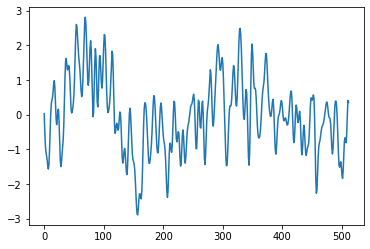

In [47]:
import matplotlib.pyplot as plt
plt.plot(background[0,:,2])
plt.show()

In [27]:
shap.DeepExplainer(a)

shap.explainers._deep.Deep

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 1, 1, 1], dtype=int8)

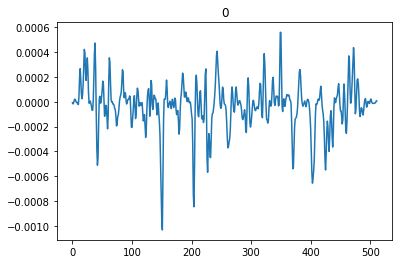

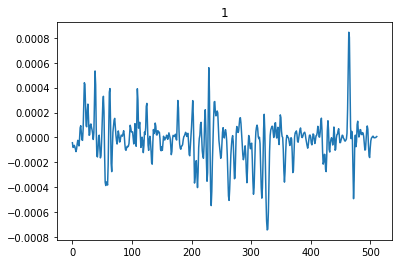

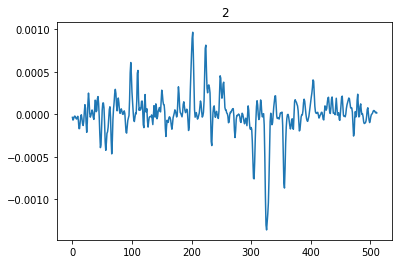

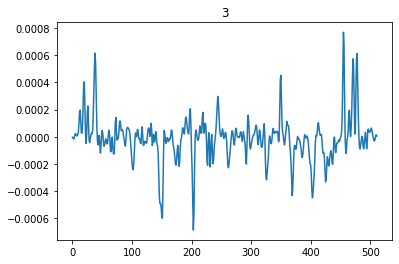

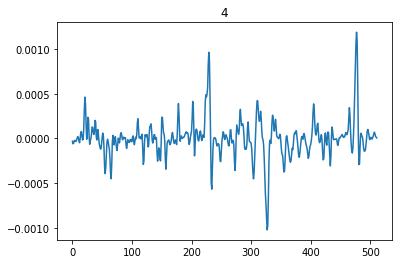

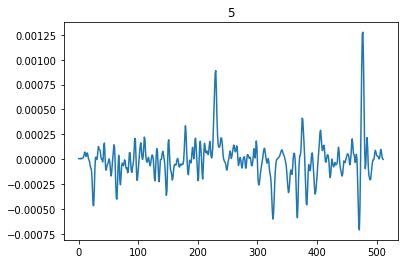

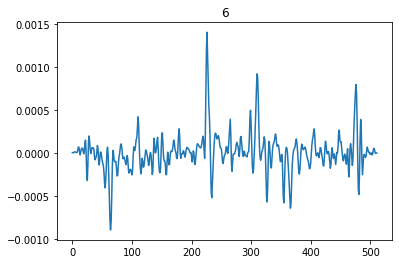

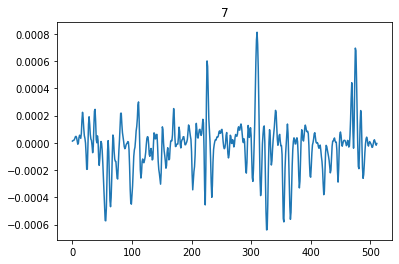

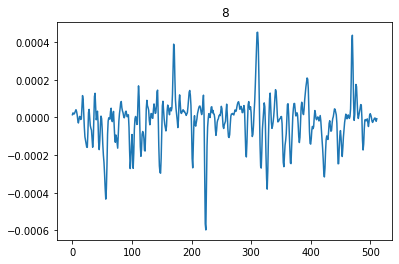

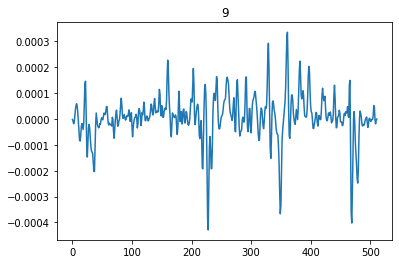

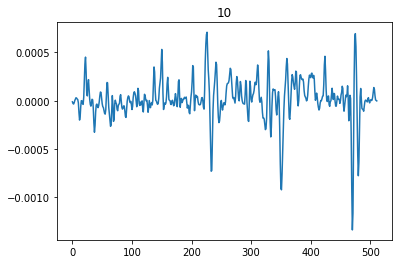

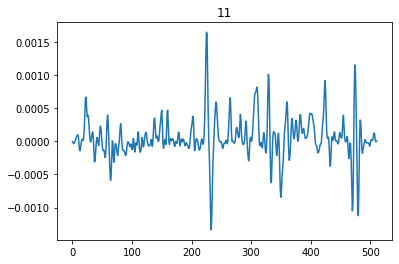

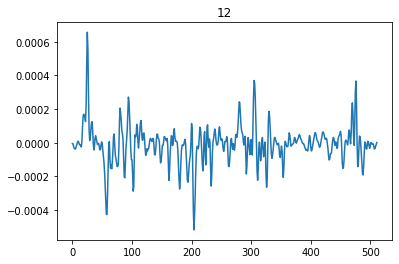

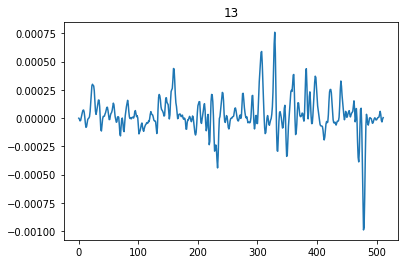

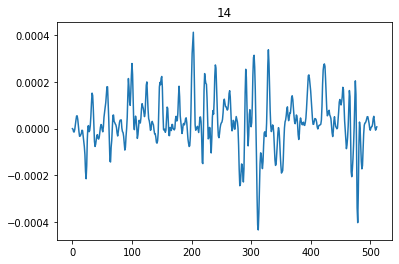

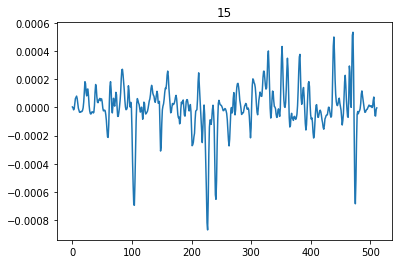

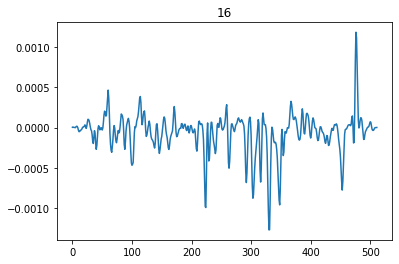

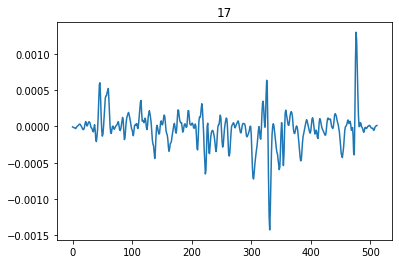

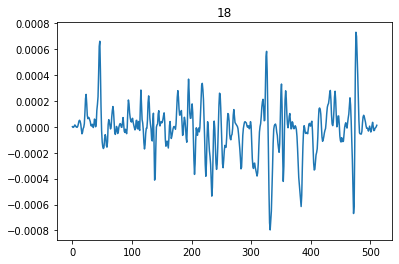

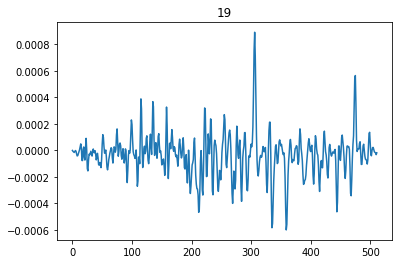

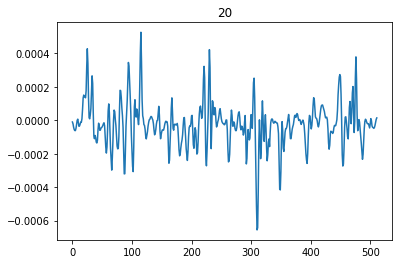

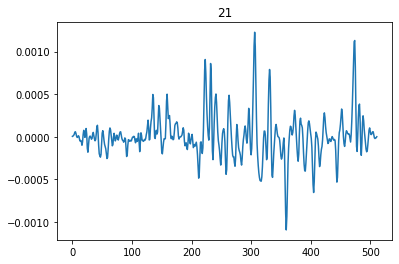

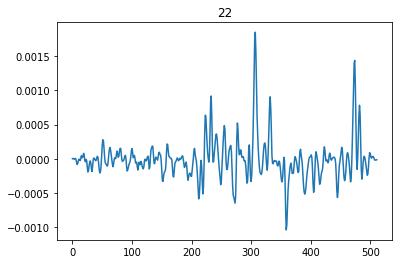

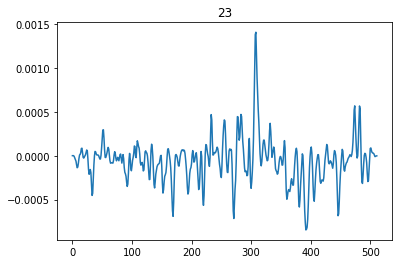

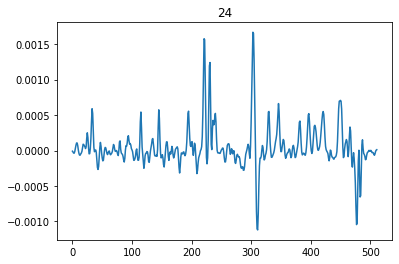

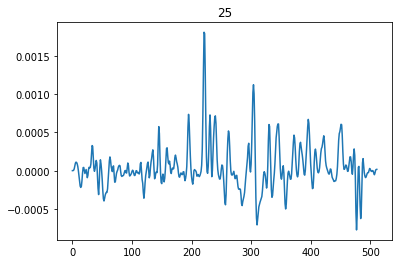

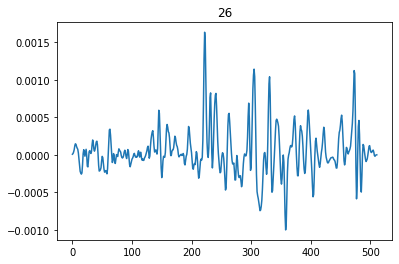

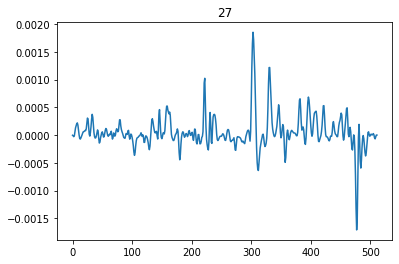

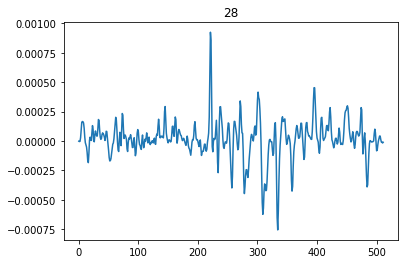

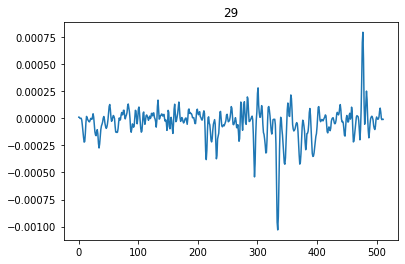

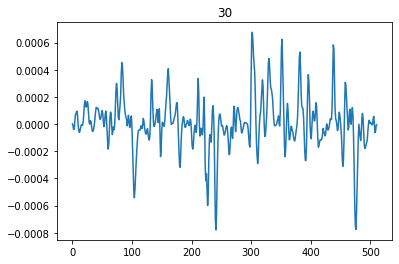

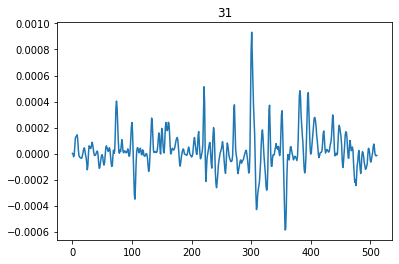

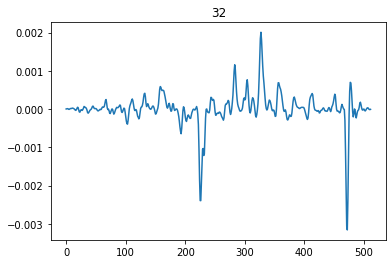

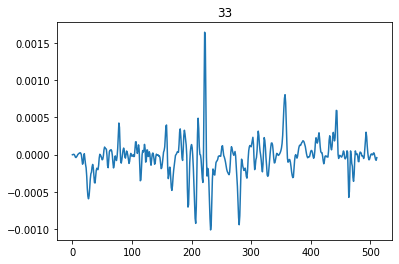

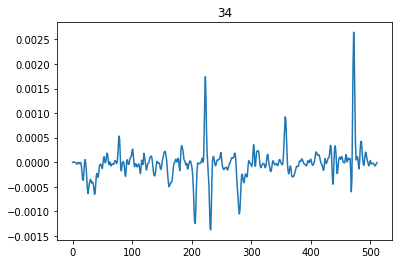

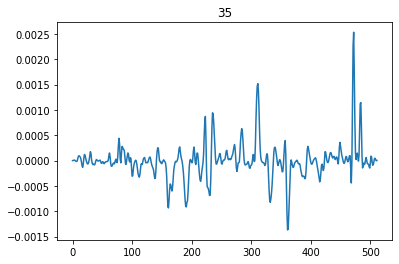

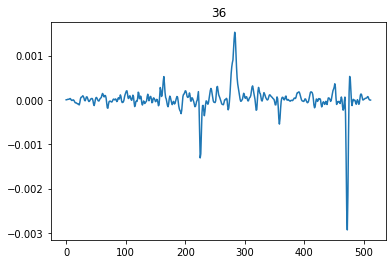

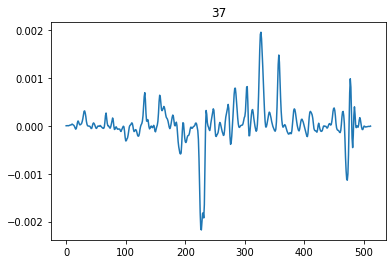

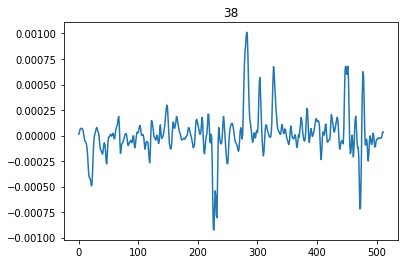

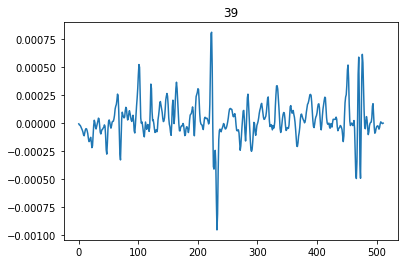

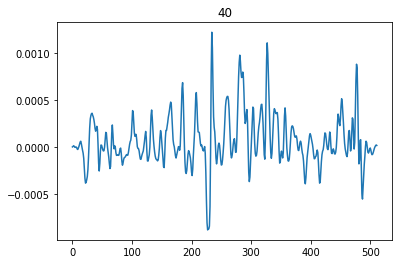

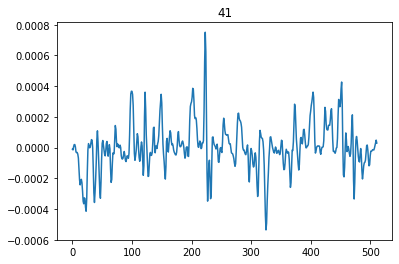

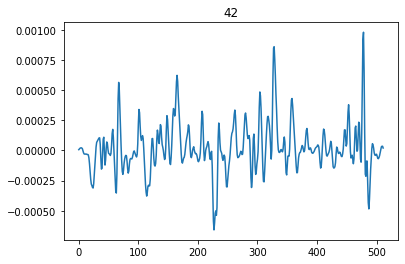

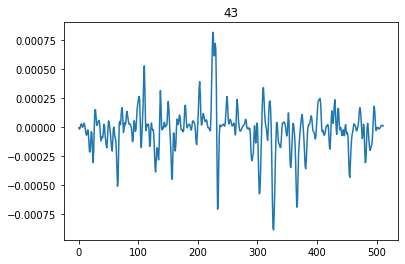

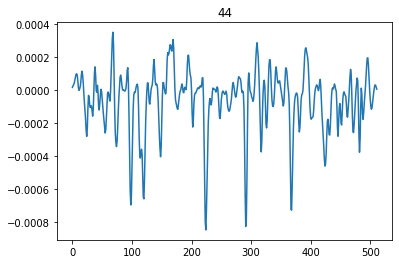

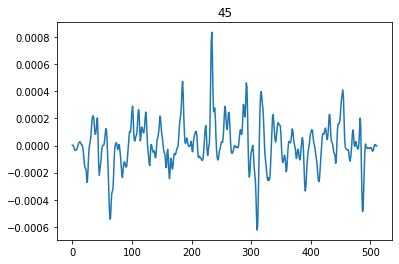

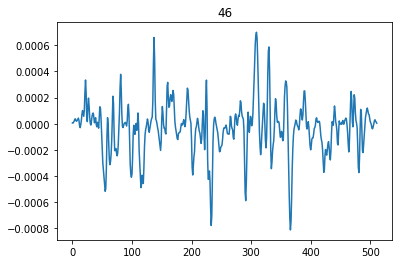

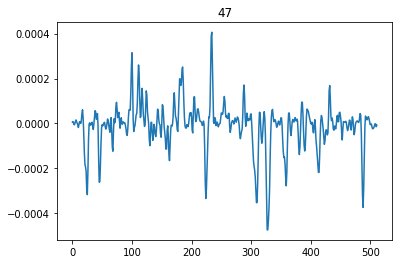

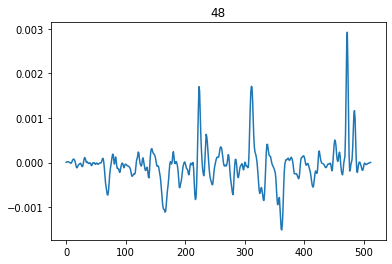

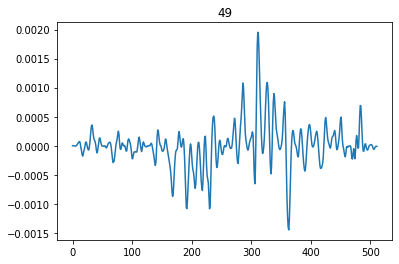

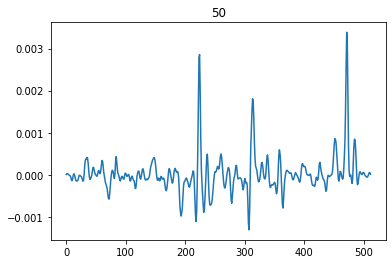

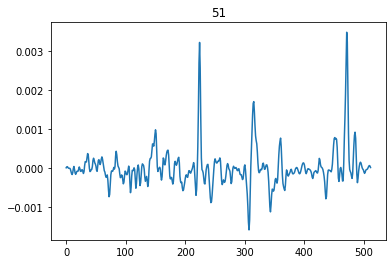

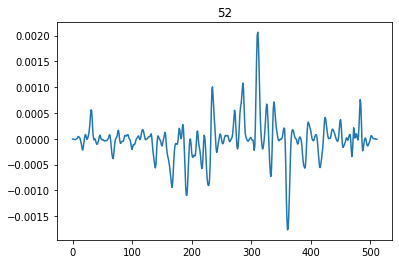

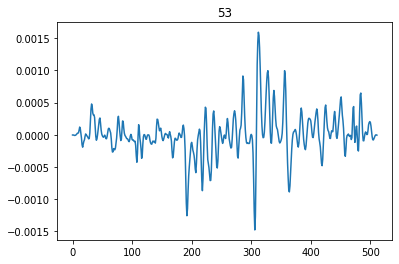

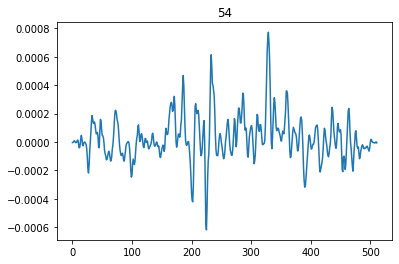

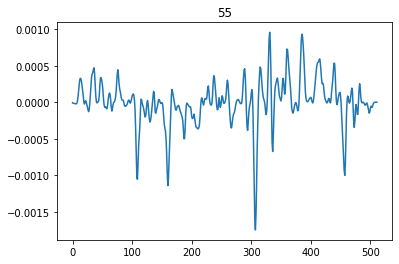

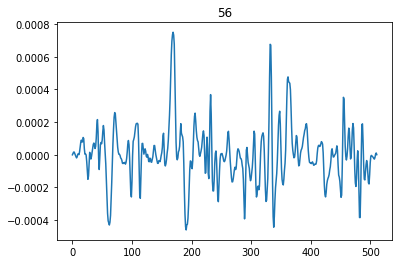

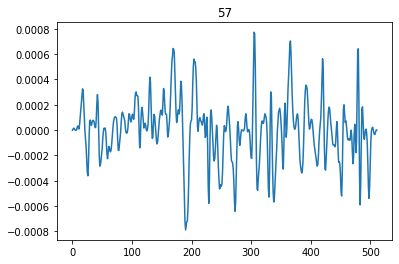

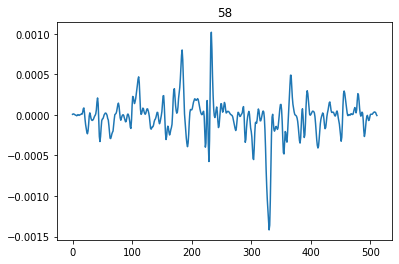

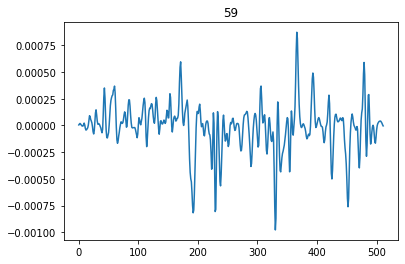

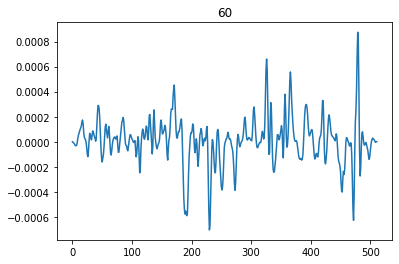

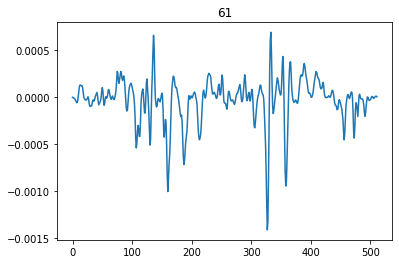

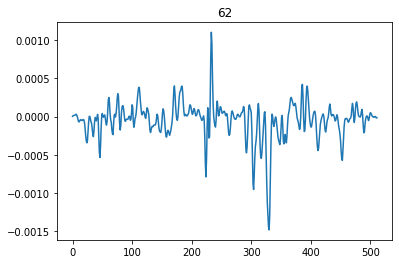

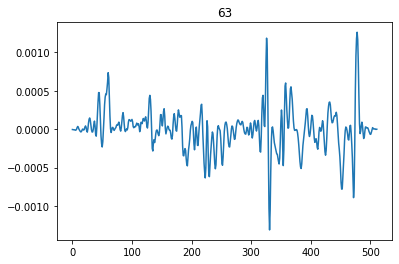

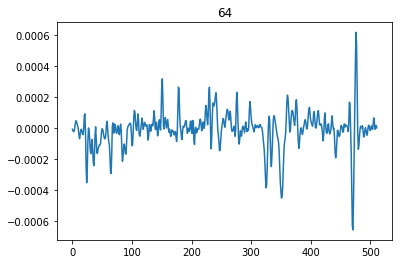

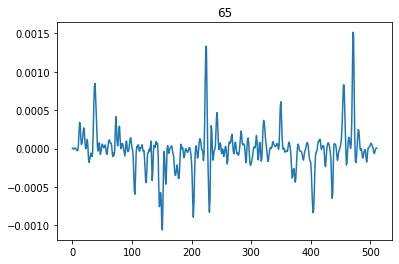

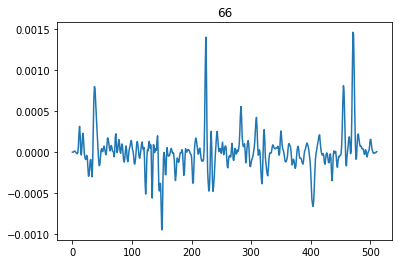

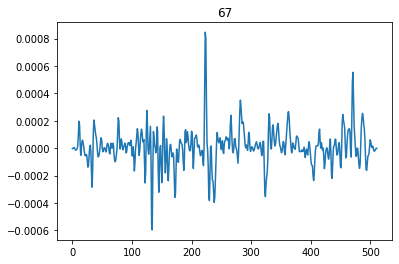

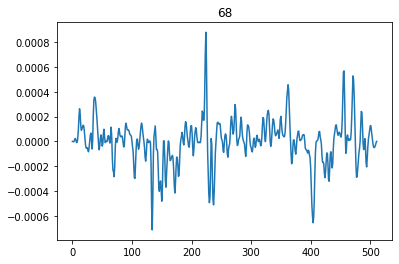

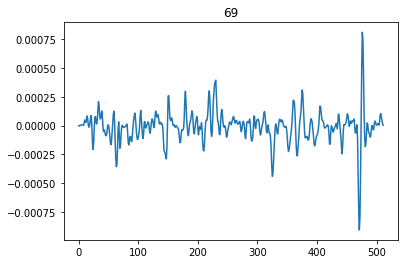

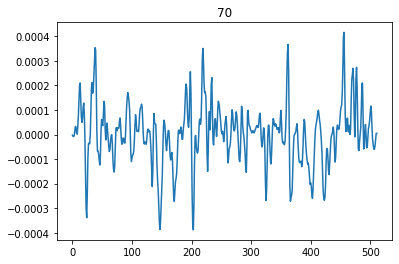

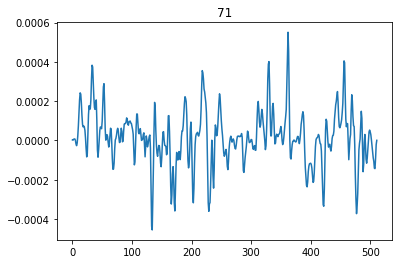

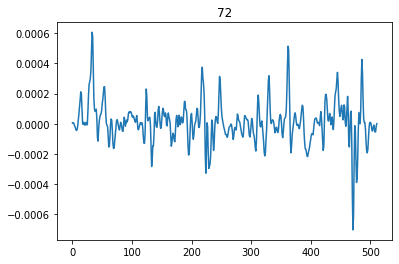

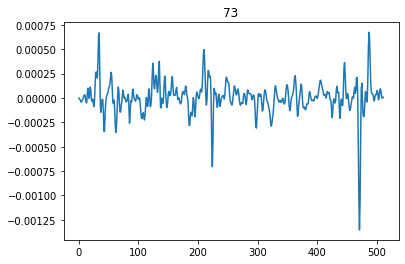

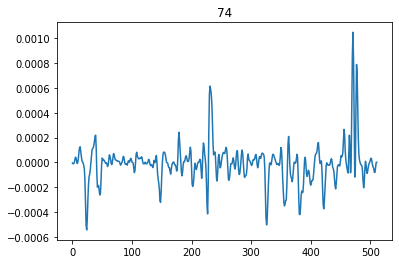

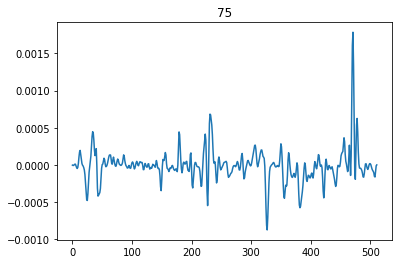

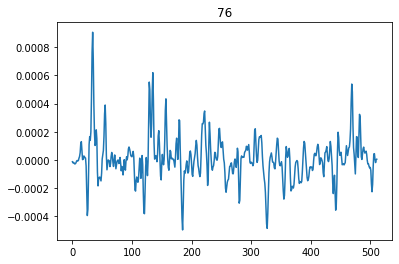

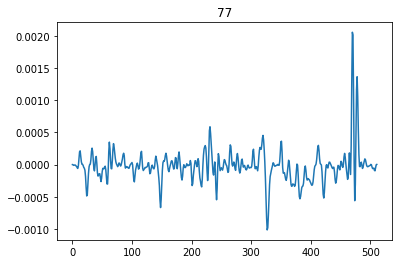

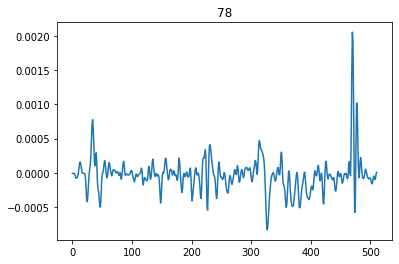

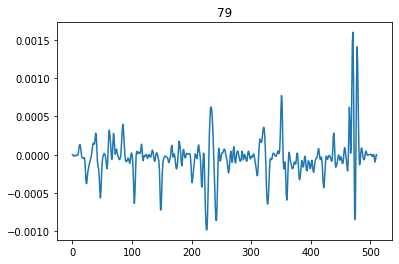

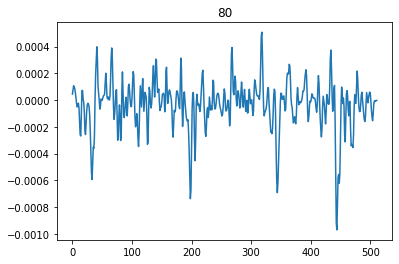

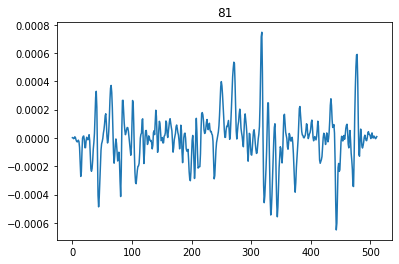

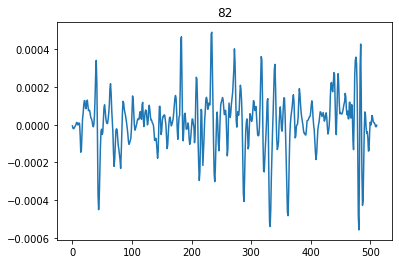

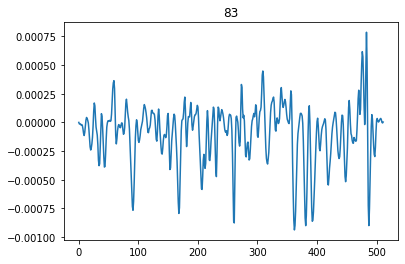

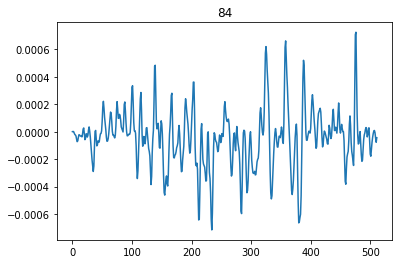

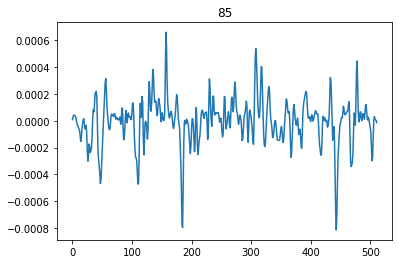

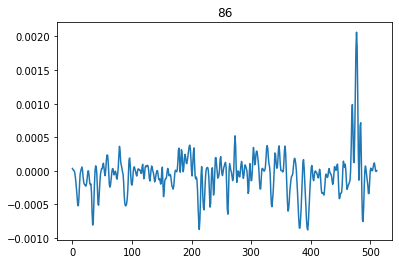

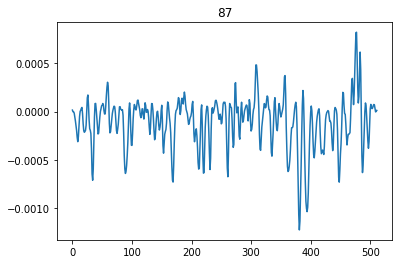

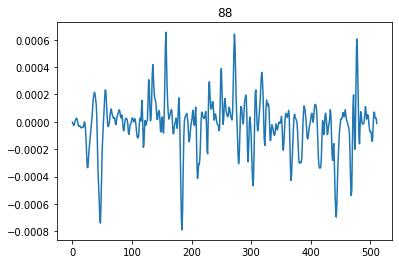

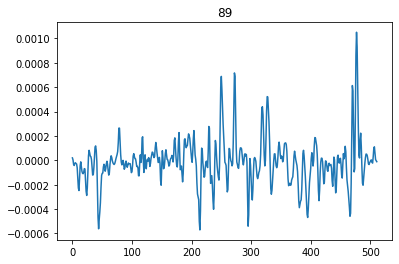

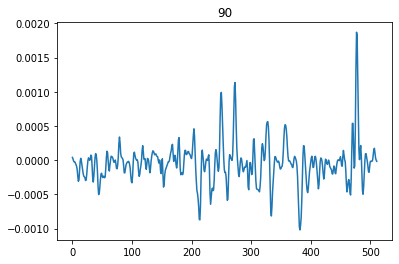

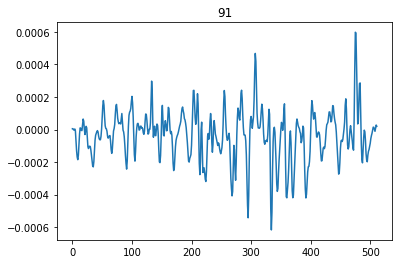

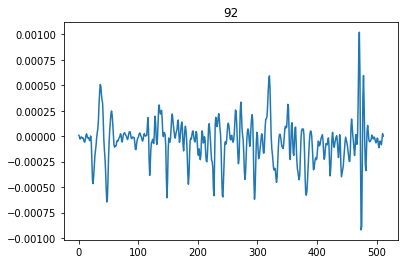

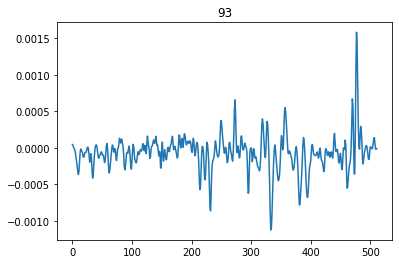

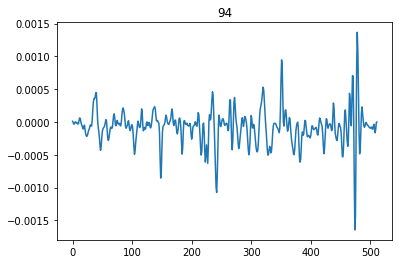

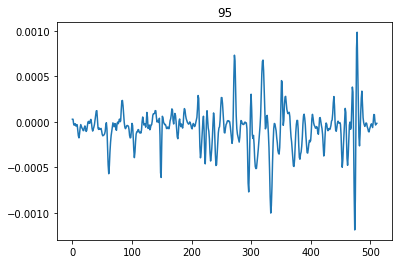

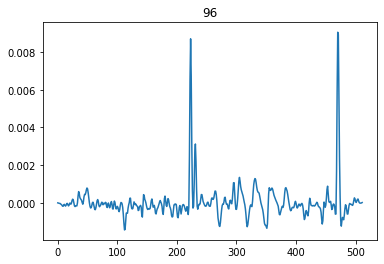

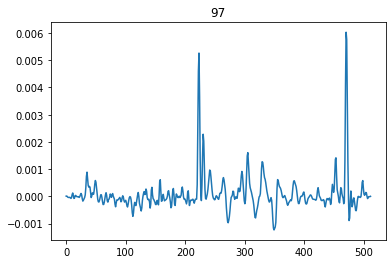

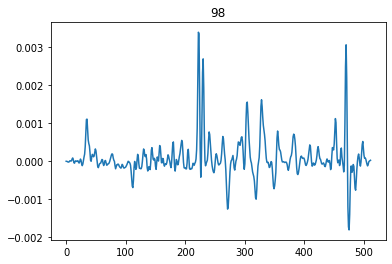

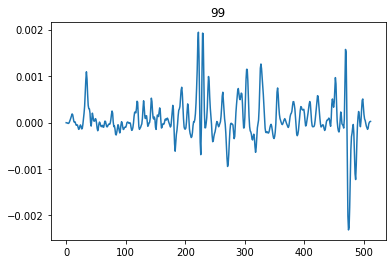

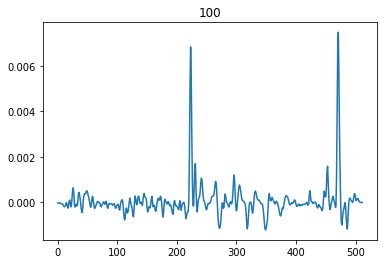

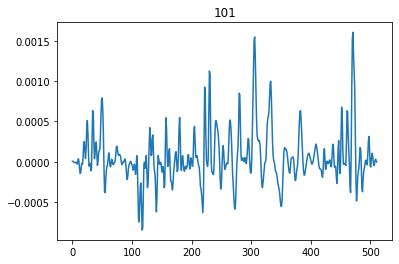

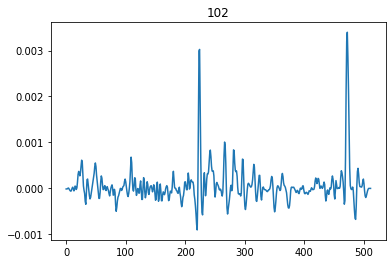

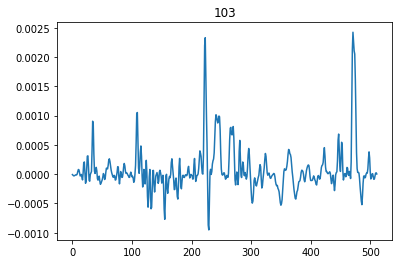

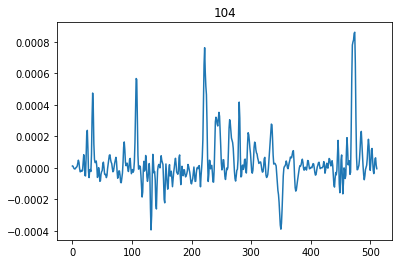

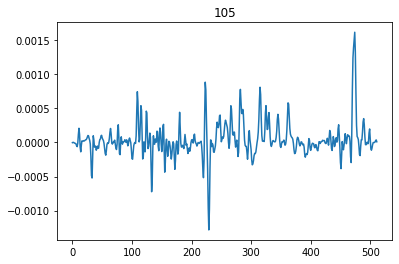

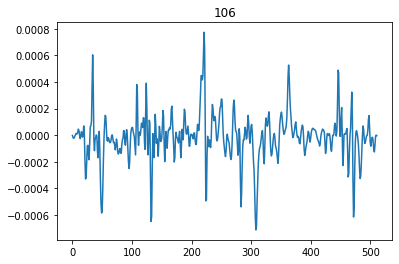

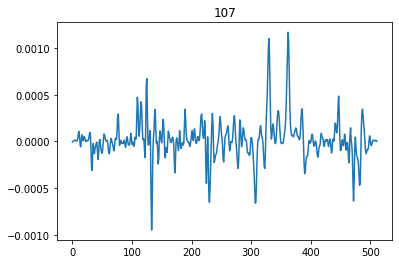

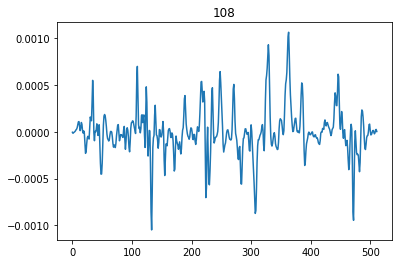

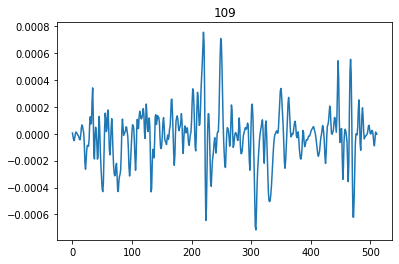

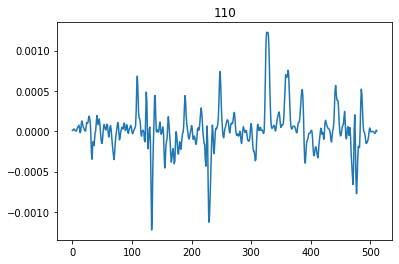

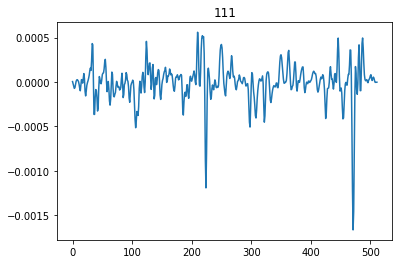

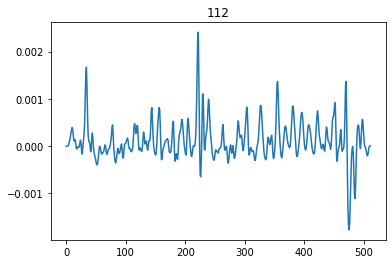

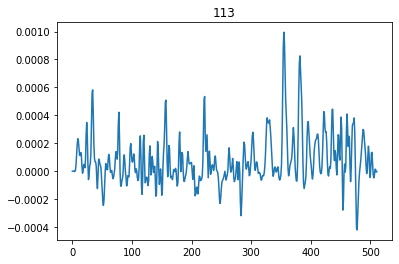

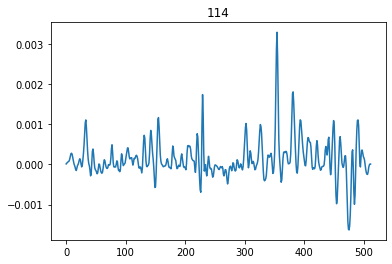

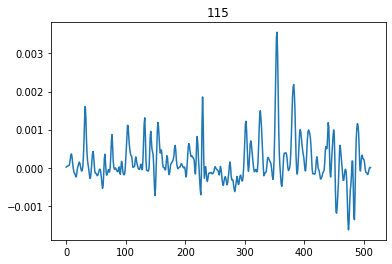

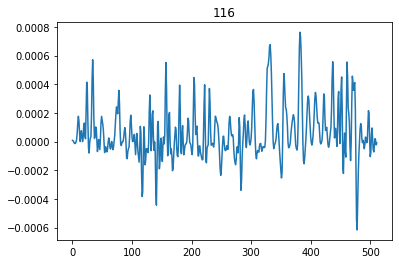

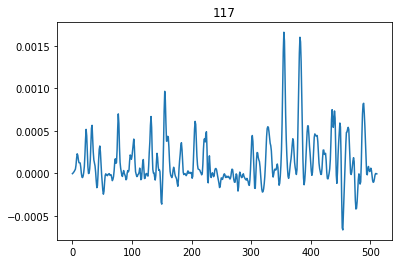

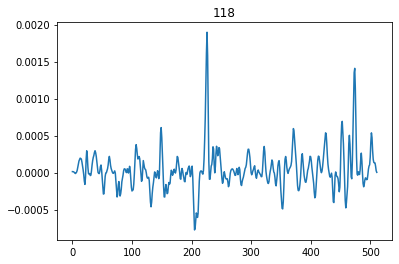

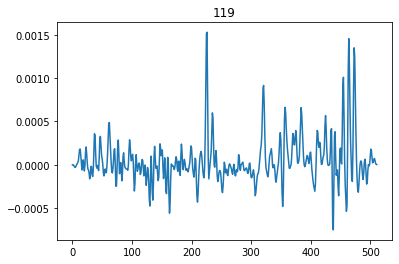

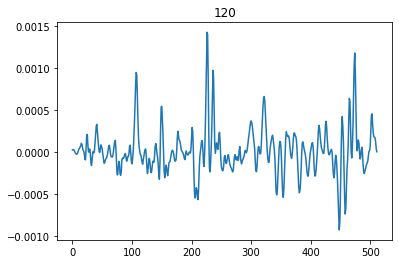

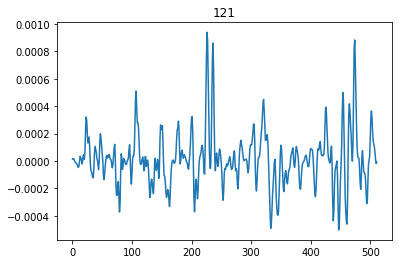

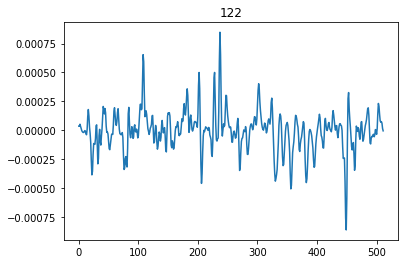

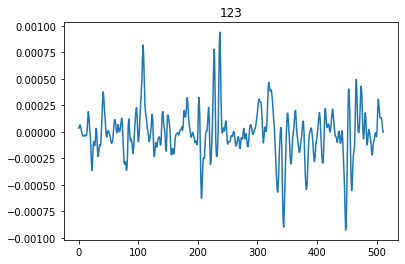

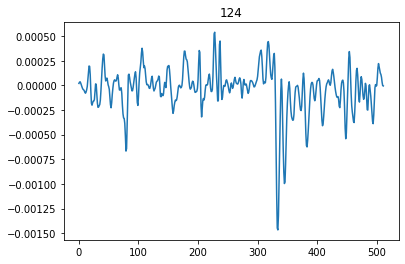

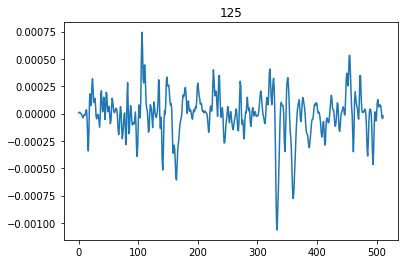

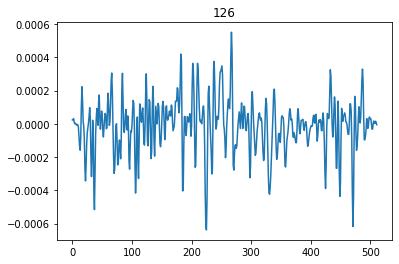

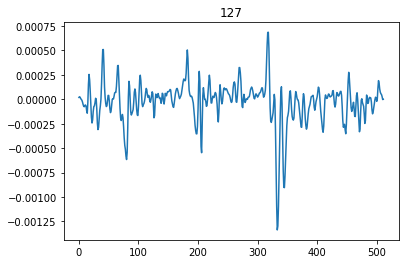

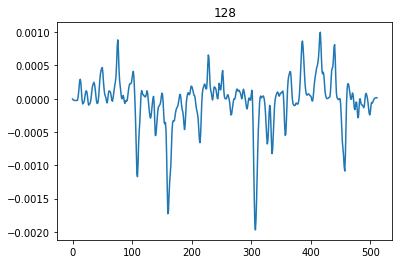

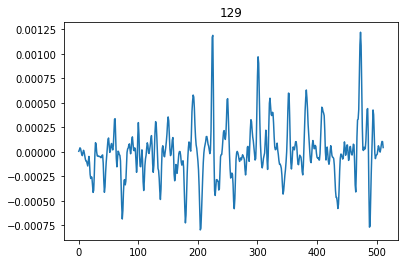

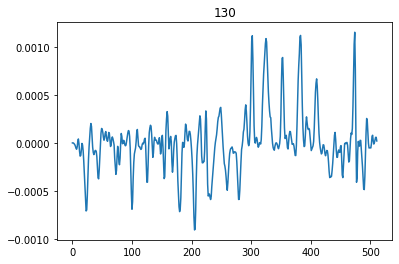

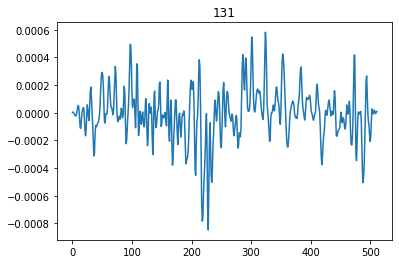

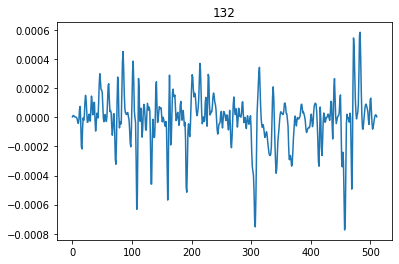

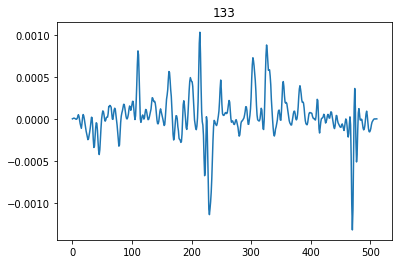

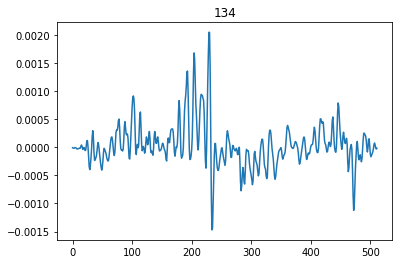

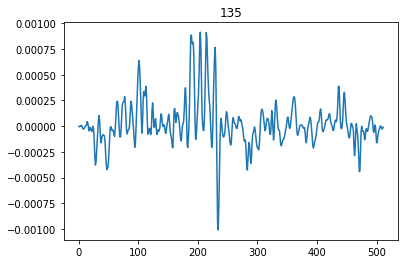

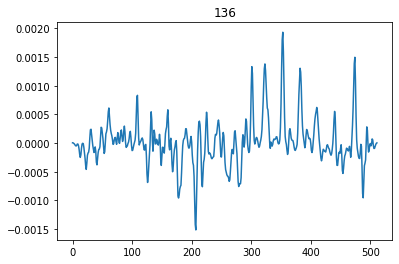

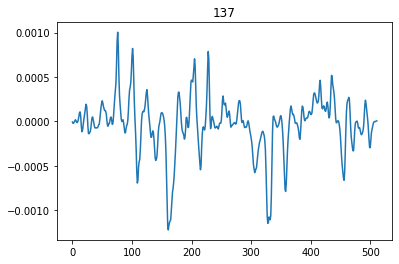

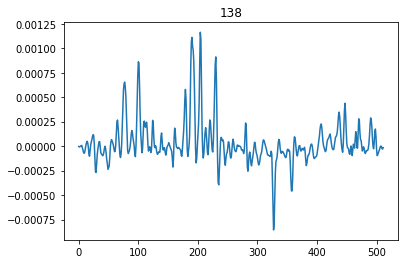

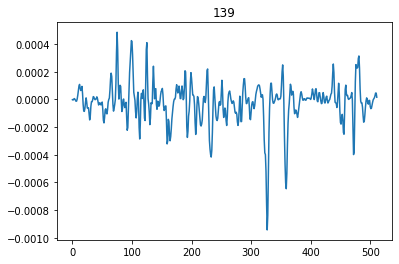

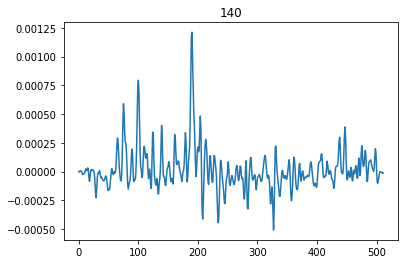

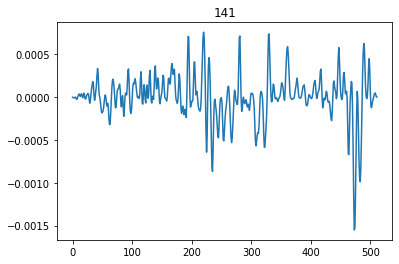

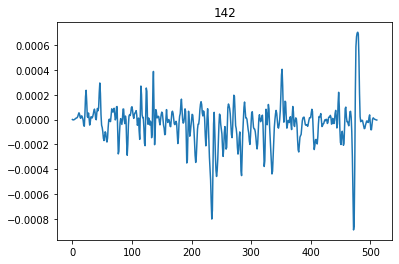

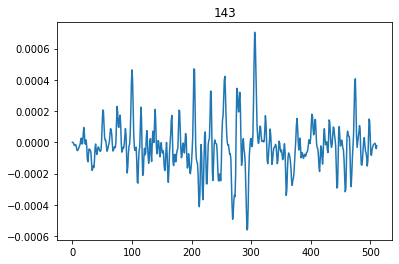

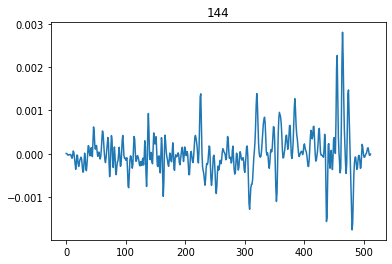

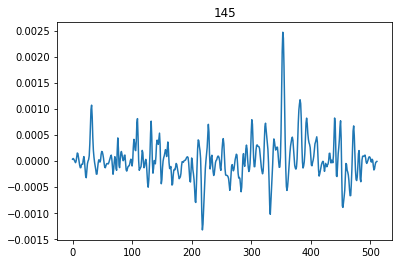

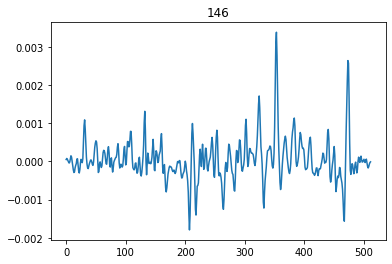

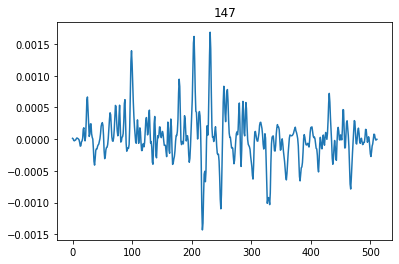

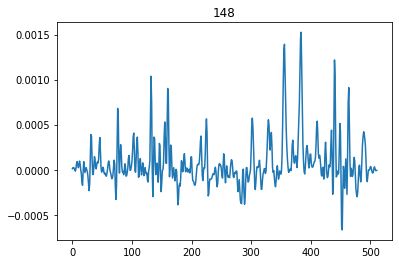

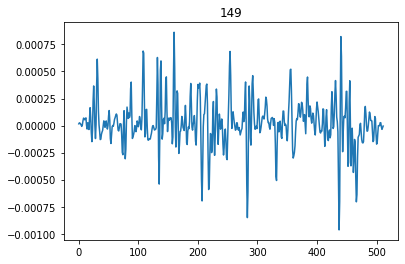

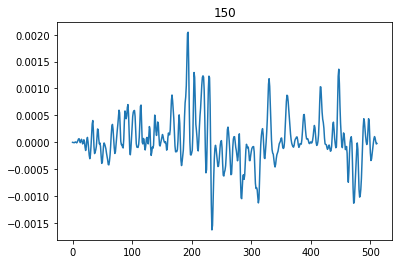

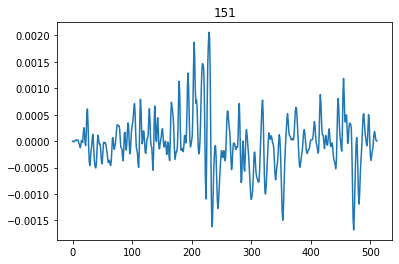

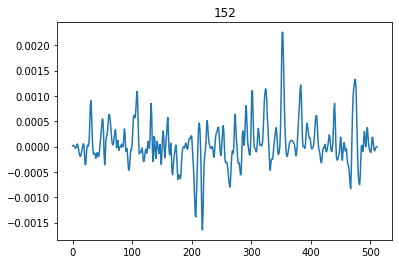

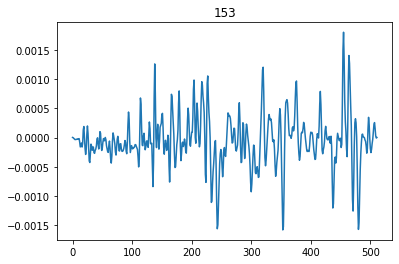

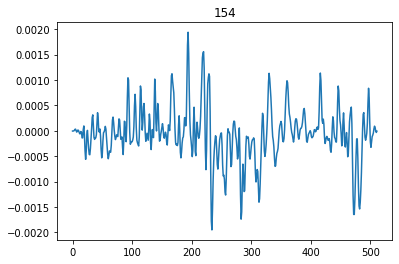

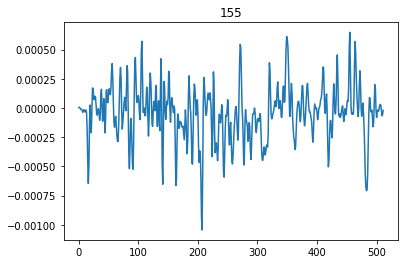

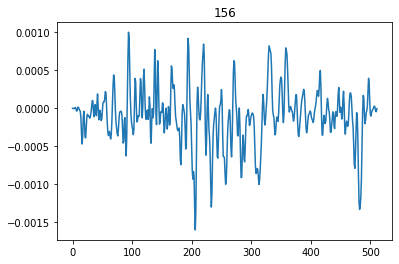

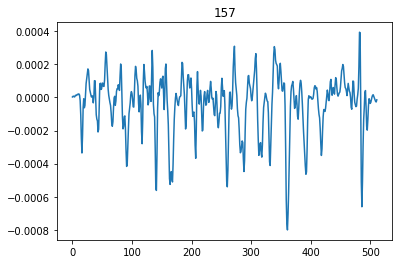

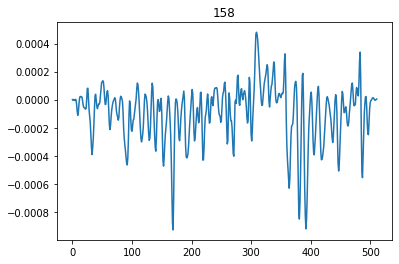

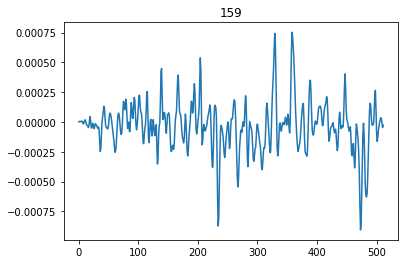

In [48]:
#
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)

#https://github.com/slundberg/shap/blob/master/shap/explainers/_deep/deep_tf.py
e = shap.GradientExplainer(last_model,background[:,:,:,np.newaxis],batch_size=1)
sv = e.shap_values(X[:1,1000:1512,:,np.newaxis])


import matplotlib.pyplot as plt


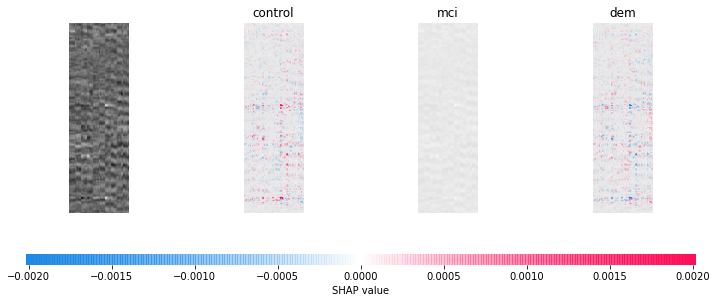

In [53]:
shap.plots.image(sv,X[:1,1000:1512,:,np.newaxis],labels=[['control','mci','dem']])